In [ ]:
import os
from pathlib import Path
import pandas as pd
import geopandas as gpd
import city2graph as c2g

import matplotlib.pyplot as plt
import warnings
# Filtra avisos chatos de geometria do Pandas
warnings.filterwarnings('ignore')
from tqdm.auto import tqdm

# Configurações visuais e de sistema
pd.set_option('display.max_columns', None)

print("Bibliotecas carrorororegadas com sucesso!")

# Configure matplotlib for publication-quality visualizations
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 10
plt.style.use('ggplot')

print("Parametros globais de gráfico!")

Bibliotecas carrorororegadas com sucesso!
Parametros globais de gráfico!


In [2]:
# ============================================
# CONFIGURAÇÕES GLOBAIS
# ============================================

CRS_METRICO = "EPSG:31983" #SIRGAS 2000 / UTM ZONA 23 SUL

## 2. Carregando os Dados

In [3]:
# ============================================
# CARREGAMENTO DA REDE VIÁRIA DE TERESINA
# ============================================

# DEFINA OS CAMINHOS DOS SEUS ARQUIVOS AQUI
caminho_edges = Path("../outputs/vectors/teresina_bbox_gnn_impedancias_topologico_edges.gpkg")
nome_camada_edge = caminho_edges.stem

caminho_nodes = Path("../outputs/vectors/teresina_bbox_gnn_impedancias_topologico_nodes.gpkg")
nome_camada_nodes = caminho_nodes.stem

# 1. Carregar os dados
print(f"Carregando arquivos '{nome_camada_edge}' e '{nome_camada_nodes}'...\n")
gdf_road = gpd.read_file(caminho_edges, layer=nome_camada_edge)
gdf_nodes = gpd.read_file(caminho_nodes, layer=nome_camada_nodes)
print("Arquivos carregadas")

Carregando arquivos 'teresina_bbox_gnn_impedancias_topologico_edges' e 'teresina_bbox_gnn_impedancias_topologico_nodes'...

Arquivos carregadas


In [4]:
gdf_nodes.head(2)

,node_id,geometry
0,0,POINT (723376.977 9408354.072)
1,1,POINT (724465.971 9415641.369)


In [5]:
# ============================================
# CARREGAMENTO DA REDE VIÁRIA DE TERESINA
# ============================================
print("Carregando pontos das UBS...")

# 1. Carregue seu arquivo de UBS (Ajuste o caminho se necessário)
# Se você tiver um arquivo .geojson, .shp ou .gpkg
caminho_ubs = '../dados/terceiros/semplam/ubs_zu.geojson'
caminho_amostra_ubs = '../dados/terceiros/semplam/ubs_zu_amostras_20perc.geojson'

gdf_ubs = gpd.read_file(caminho_ubs)
gdf_ubs_amostras = gpd.read_file(caminho_amostra_ubs)

# 2. Padronização de CRS (Obrigatório ser igual ao Grafo: EPSG:31983)
if gdf_ubs.crs.to_string() != "EPSG:31983":
    print(f"\nConvertendo UBS de {gdf_ubs.crs} para EPSG:31983...")
    gdf_ubs = gdf_ubs.to_crs("EPSG:31983")

if gdf_ubs_amostras.crs.to_string() != "EPSG:31983":
    print(f"Convertendo UBS (Amostra) de {gdf_ubs_amostras.crs} para EPSG:31983...\n")
    gdf_ubs_amostras = gdf_ubs_amostras.to_crs("EPSG:31983")

if gdf_road.crs.to_string() != "EPSG:31983":
    print(f"Convertendo ROAD de {gdf_road.crs} para EPSG:31983...")
    gdf_road = gdf_road.to_crs("EPSG:31983")

print(f"Total de UBS carregadas: {len(gdf_ubs)}")
print(f"CRS Ativo: {gdf_ubs.crs}")
print(f"Total de UBS (Amostras) carregadas: {len(gdf_ubs_amostras)}")
print(f"CRS Ativo: {gdf_ubs_amostras.crs}")
print(f"\nTotal de ROAD carregadas: {len(gdf_road)}")
print(f"CRS Ativo: {gdf_road.crs}")

Carregando pontos das UBS...

Convertendo UBS de EPSG:4674 para EPSG:31983...
Convertendo UBS (Amostra) de EPSG:4674 para EPSG:31983...

Total de UBS carregadas: 75
CRS Ativo: EPSG:31983
Total de UBS (Amostras) carregadas: 18
CRS Ativo: EPSG:31983

Total de ROAD carregadas: 62046
CRS Ativo: EPSG:31983


In [ ]:
print("Convertendo malha viária para Grafo NetworkX...")

# approach='primal': Nós são intersecções, Arestas são ruas
G = c2g.morphology.segments_to_graph(
    segments_gdf = gdf_road,
    multigraph = True,
    as_nx = True,
)

print("Grafo criado com sucesso!")
# print(f"Número de Nós: {G.number_of_nodes()}")
# print(f"Número de Arestas: {G.number_of_edges()}")

# 2. Verificação de Atributos
# Vamos confirmar se as colunas de tempo entraram no grafo
# exemplo_aresta = list(G.edges(data=True))[20000] # Pega a primeira rua
# print("\n--- ATRIBUTOS DA PRIMEIRA ARESTA ---")
# print(f"Tempo Carro: {exemplo_aresta[2].get('time_carro_min')} min")
# print(f"Tempo Pé:    {exemplo_aresta[2].get('time_ape_min')} min")

Convertendo malha viária para Grafo NetworkX...
Grafo criado com sucesso!


## 5. Cálculo das Isócronas

In [15]:
# Visualiza as primeiras linhas para garantir que leu certo
gdf_ubs.head()

,fid,nome,cnes,logradouro,numero,bairro,cep,regional,geometry
0,1,UBS A BENICIO FREIRE E SILVA-POTY VELHO,2588811,RUA MARIO AUGUSTO FREITAS,1469,POTY VELHO,64005830,NORTE,POINT (740835.065 9442861.74)
1,2,UBS DR. CARLOS ALBERTO CORDEIRO,6404057,RUA EDMILSON PAIXAO,S/N,DIRCEUII,64078271,SUDESTE,POINT (748460.94 9434826.331)
2,3,UBS DR DURVALINO COUTO,2406624,AV ERCINIO FORTES,S/N,BELA VISTA,64031090,SUL,POINT (746492.593 9431960.513)
3,4,UBS DR EVALDO CARVALHO- NOVA BRASILIA,2406845,RUA ANISIO PIRES,S N,NOVA BRASILIA,64004550,NORTE,POINT (740574.523 9440972.801)
4,5,UBS DR FELIPE EULALIO DE PADUA-PROMORAR,6901468,PRACA DO CENTRO DE PRODUCAO DO PROMORAR,QD 61,PROMORAR,64027140,SUL,POINT (745907.107 9430564.831)


### 5.2 Função das Isocrona

##### Célula: Geração de Isócronas com City2Graph (Alpha Shape)

In [ ]:


def gerar_isocronas_alpha(grafo, gdf_pontos, hull_ratio=0.3, modo='carro', limiares=[10, 20, 30]):
    """
    Gera isócronas usando o algoritmo nativo Alpha Shape do City2Graph.
    
    Parâmetros:
        grafo (nx.Graph): Grafo viário preparado.
        gdf_pontos (GeoDataFrame): Pontos de origem (UBS).
        modo (str): 'car' ou 'walk' (seleciona a impedância).
        limiares (list): Lista de tempos em minutos (ex: [10, 20, 30]).
    """
    attr_peso = f'time_{modo}_min'
    print(f"🚀 Iniciando cálculo Alpha Shape para {len(gdf_pontos)} UBS (Modo: {modo})...")
    
    resultados_finais = []
    
    # Barra de progresso para acompanhar o processamento
    for idx, row in tqdm(gdf_pontos.iterrows(), total=len(gdf_pontos)):
        try:
            # Dados da UBS atual
            ponto_ubs = row.geometry
            nome_ubs = row.get('no_fantasi', row.get('nome', f"UBS_{idx}"))
            cnes = row.get('cnes', 0)
            
            poligonos_cumulativos = []
            
            # --- 1. GERAÇÃO DOS POLÍGONOS (CUMULATIVOS) ---
            for tempo in limiares:
                # Chama a função nativa do City2Graph
                # Ela retorna um GeoDataFrame contendo a isócrona
                gdf_iso = c2g.utils.create_isochrone(
                    graph=grafo,
                    center_point=ponto_ubs,
                    threshold=tempo,           # Limite de tempo (ex: 10 min)
                    edge_attr=attr_peso,       # Coluna de peso (ex: 'time_car_min')
                    method='concave_hull_alpha', # <--- O SEGREDO (Alpha Shape)
                    hull_ratio=hull_ratio,            # Ajuste de "concavidade" (0.0 a 1.0)
                    allow_holes=False          # Evita buracos dentro da mancha
                )
                
                # Se a função retornou geometria válida, guarda.
                if not gdf_iso.empty and not gdf_iso.geometry.iloc[0].is_empty:
                    poligonos_cumulativos.append(gdf_iso.geometry.iloc[0])
                else:
                    # Fallback: Se não achou nada (isolada), cria um ponto bufferizado
                    poligonos_cumulativos.append(ponto_ubs.buffer(50))

            # --- 2. CÁLCULO DAS DIFERENÇAS (ANÉIS/DONUTS) ---
            # Garante geometria válida com buffer(0)
            poly_10 = poligonos_cumulativos[0].buffer(0)
            poly_20 = poligonos_cumulativos[1].buffer(0)
            poly_30 = poligonos_cumulativos[2].buffer(0)
            
            # Subtrai as áreas para não haver sobreposição
            zona_1 = poly_10                                 # 0 a 10
            zona_2 = poly_20.difference(poly_10)             # 10 a 20
            zona_3 = poly_30.difference(poly_20)             # 20 a 30
            
            # --- 3. ESTRUTURAÇÃO DO DADO ---
            gdf_temp = gpd.GeoDataFrame({
                'id_ubs': [nome_ubs]*3,
                'cnes': [cnes]*3,
                'faixa': ['0-10', '10-20', '20-30'],
                'tempo_limite': limiares,
                'modo': [modo]*3
            }, geometry=[zona_1, zona_2, zona_3], crs=gdf_pontos.crs)
            
            resultados_finais.append(gdf_temp)
            
        except Exception as e:
            # print(f"Erro na UBS {idx}: {e}") # Descomente para debug detalhado
            continue
            
    # Consolida tudo num único arquivo
    if resultados_finais:
        return pd.concat(resultados_finais, ignore_index=True)
    else:
        return gpd.GeoDataFrame()

print("🏁 Função 'gerar_isocronas_alpha' compilada e pronta.")

🏁 Função 'gerar_isocronas_alpha' compilada e pronta.


### 5.3 Execução da função Isocrona e Exportação dos Resultados

In [ ]:
# Célula: Execução dos Cenários e Exportação

# Cria pasta de saída
os.makedirs("../outputs/vectors/amostra/", exist_ok=True)

In [27]:
# --- CENÁRIO 1: CARRO ---
gdf_carro = gerar_isocronas_alpha(G, gdf_ubs_amostras, hull_ratio=0.3, modo='carro', limiares=[5,10,15])

if not gdf_carro.empty:
    path_car = "../outputs/vectors/amostra/iso_alpha_carro_051015_hr03_amostra.geojson"
    gdf_carro.to_file(path_car, driver="GeoJSON", crs=CRS_METRICO, engine='fiona')
    print(f"💾 Isócronas de CARRO salvas em: {path_car}")

🚀 Iniciando cálculo Alpha Shape para 18 UBS (Modo: carro)...


100%|██████████| 18/18 [02:24<00:00,  8.03s/it]


ImportError: the 'to_file' method requires the 'fiona' package, but it is not installed or does not import correctly.
Importing fiona resulted in: No module named 'fiona'

In [24]:
# --- CENÁRIO 2: A PÉ ---
gdf_walk = gerar_isocronas_alpha(G, gdf_ubs_amostras, hull_ratio=0.25, modo='ape')

if not gdf_walk.empty:
    path_walk = "../outputs/vectors/amostra/iso_alpha_ape_025_amostra.geojson"
    gdf_walk.to_file(path_walk, driver="GeoJSON")
    print(f"💾 Isócronas A PÉ salvas em: {path_walk}")

🚀 Iniciando cálculo Alpha Shape para 18 UBS (Modo: ape)...


100%|██████████| 18/18 [00:10<00:00,  1.68it/s]


💾 Isócronas A PÉ salvas em: ../outputs/vectors/amostra/iso_alpha_ape_025_amostra.geojson


### 5.4 Visualização do Resultado

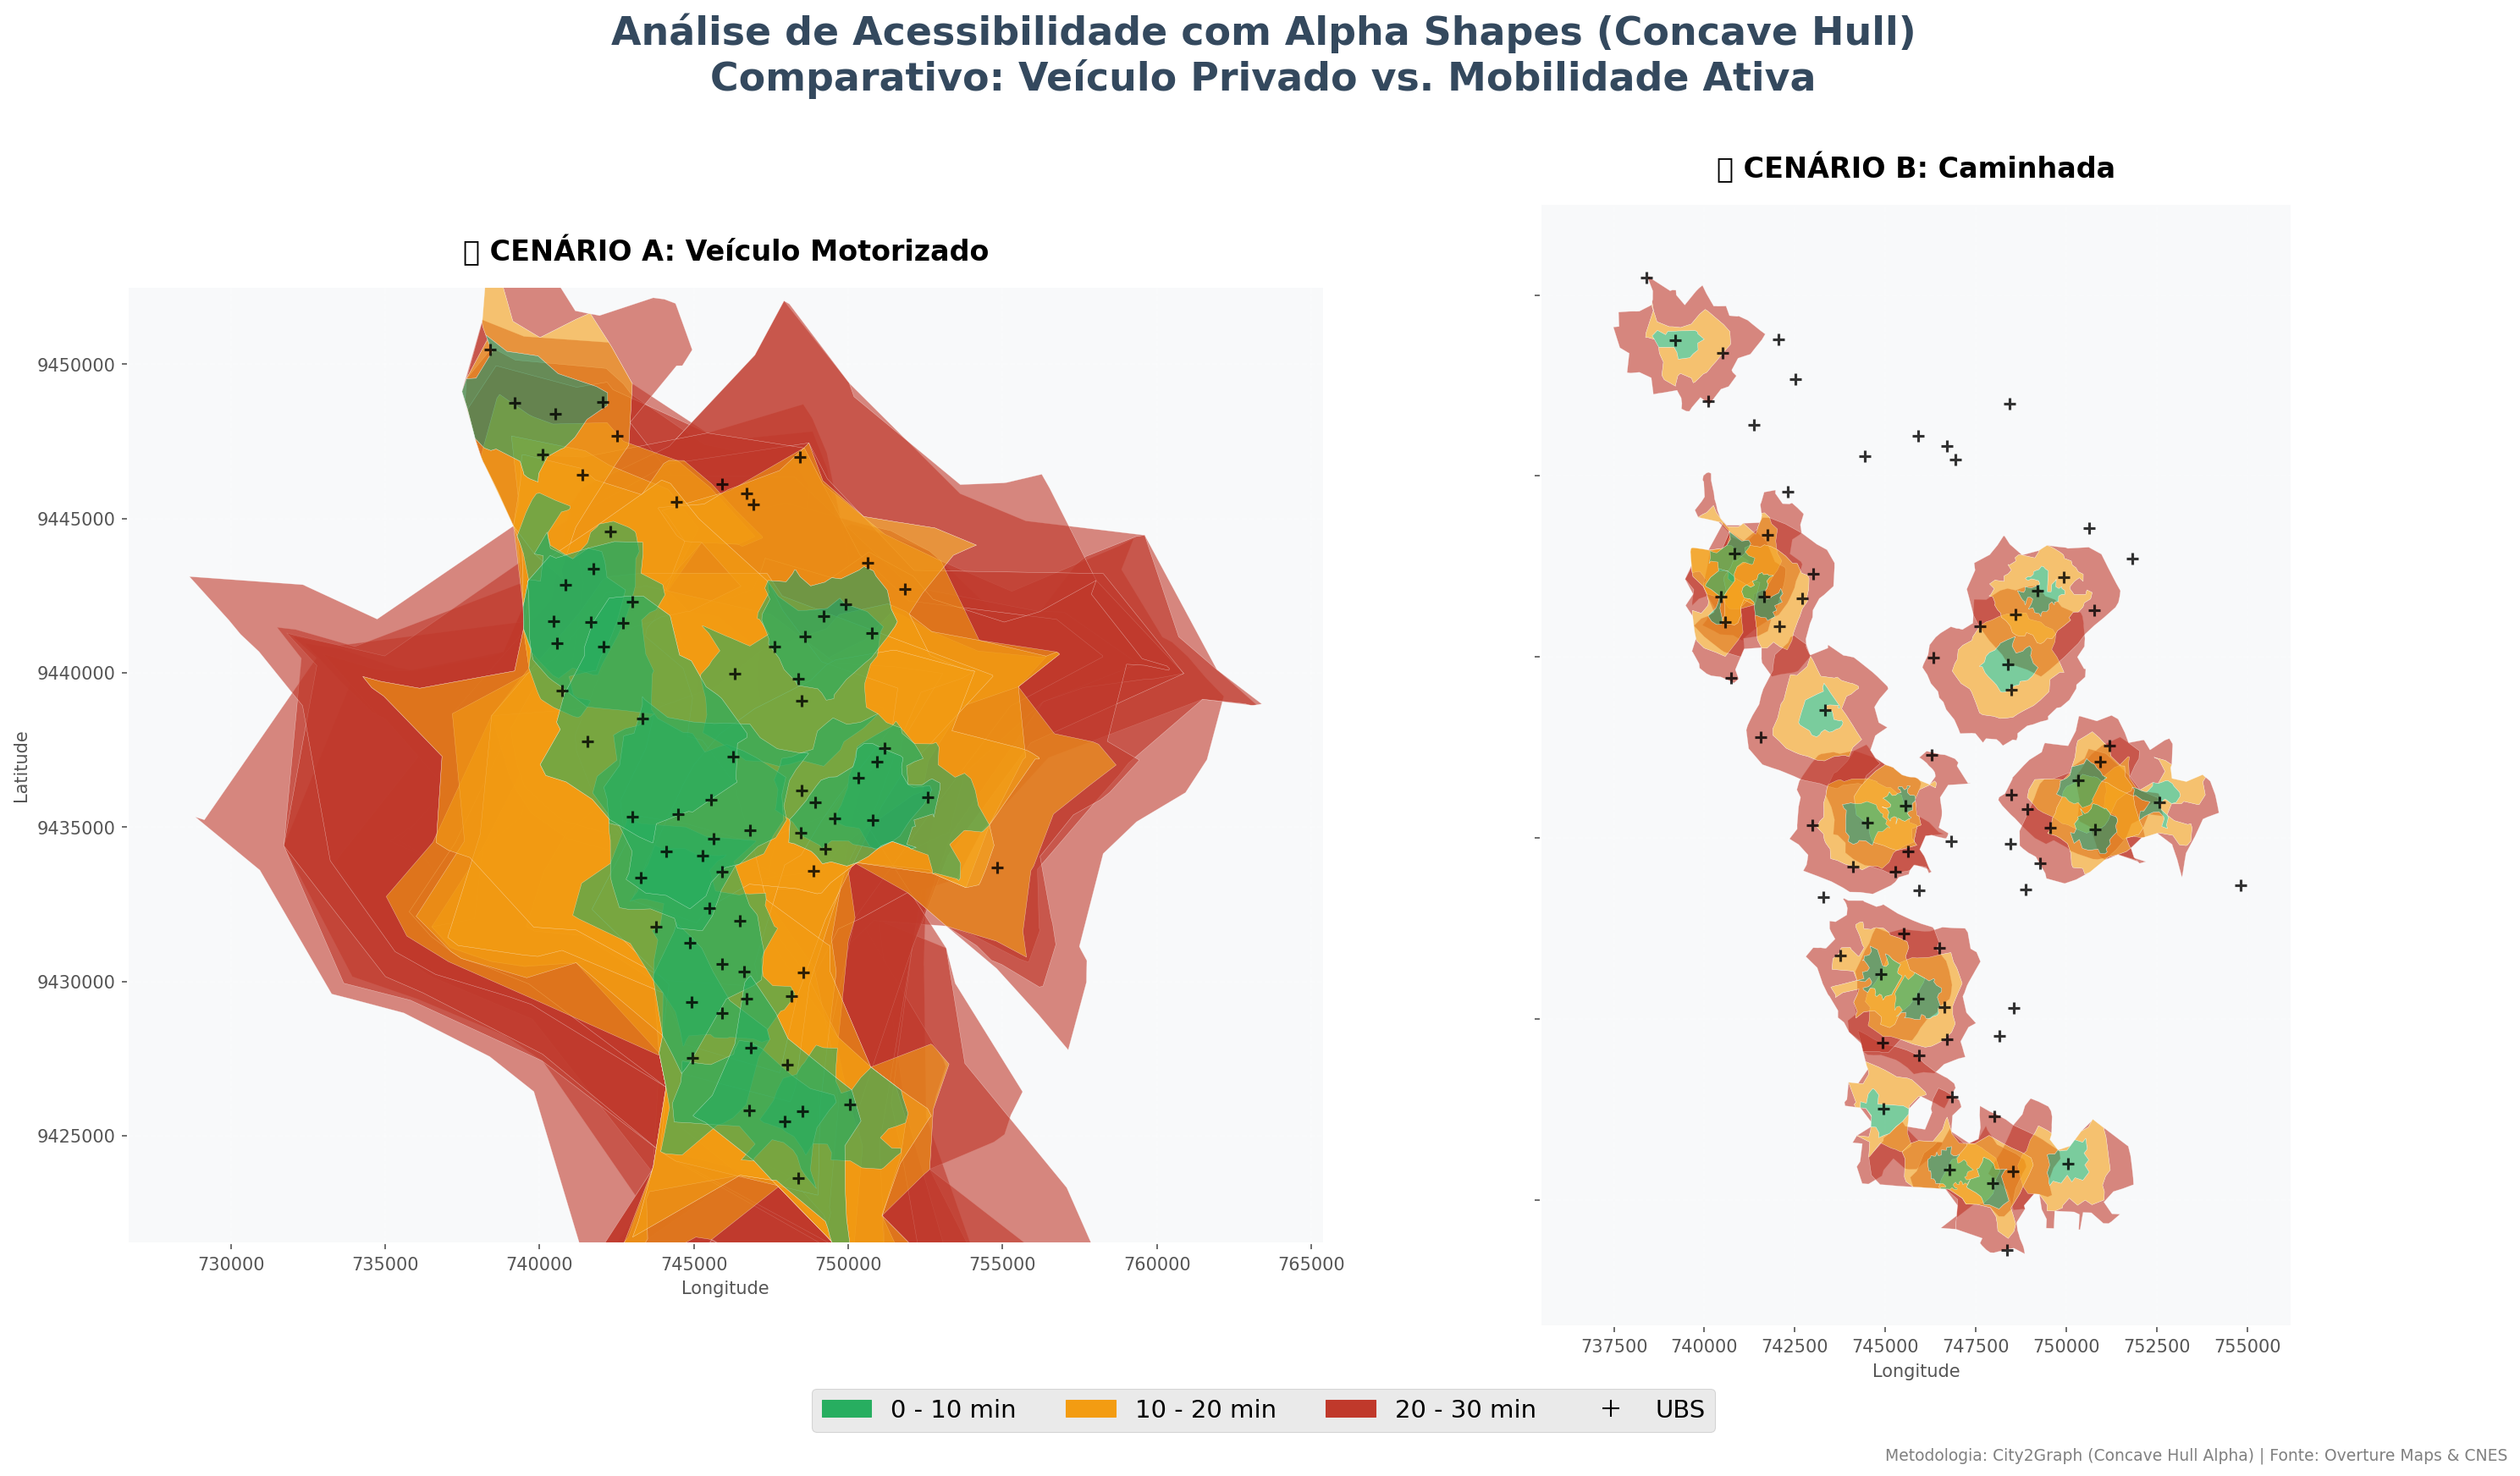

In [29]:
# Célula: Visualização Cartográfica Profissional (Comparativo)
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plotar_comparacao_alpha(gdf_c, gdf_w, pontos_ubs):
    # Cores semânticas (Verde=Perto, Amarelo=Médio, Vermelho=Longe)
    cores = {'0-10': '#27ae60', '10-20': '#f39c12', '20-30': '#c0392b'}
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 12), sharey=True)
    
    # Título Principal
    fig.suptitle('Análise de Acessibilidade com Alpha Shapes (Concave Hull)\nComparativo: Veículo Privado vs. Mobilidade Ativa', 
                 fontsize=22, weight='bold', color='#34495e', y=0.96)

    # Configuração dos Cenários
    cenarios = [
        (gdf_c, axes[0], "CENÁRIO A: Veículo Motorizado", "🚗"),
        (gdf_w, axes[1], "CENÁRIO B: Caminhada", "🚶")
    ]

    for gdf, ax, titulo, icone in cenarios:
        if gdf.empty: continue
        
        # 1. Plotagem das Isócronas (Do maior para o menor para garantir visibilidade)
        # Como usamos Alpha Shape, as formas serão orgânicas e recortadas
        for faixa in ['20-30', '10-20', '0-10']:
            subset = gdf[gdf['faixa'] == faixa]
            if not subset.empty:
                subset.plot(ax=ax, color=cores[faixa], alpha=0.6, edgecolor='white', linewidth=0.2)
        
        # 2. Plotagem das UBS
        pontos_ubs.plot(ax=ax, color='black', marker='+', markersize=40, zorder=5, alpha=0.8)
        
        # 3. Estética do Mapa
        ax.set_title(f"{icone} {titulo}", fontsize=16, weight='bold', pad=15)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_xlabel("Longitude", fontsize=10)
        ax.ticklabel_format(style='plain', useOffset=False)
        ax.set_facecolor('#f8f9fa') # Fundo levemente cinza para contraste
        
        # Limites automáticos com margem
        if not gdf.empty:
            minx, miny, maxx, maxy = gdf.total_bounds
            ax.set_xlim(minx-2000, maxx+2000)
            ax.set_ylim(miny-2000, maxy+2000)
        
        if ax == axes[0]: ax.set_ylabel("Latitude", fontsize=10)

    # 4. Legenda Personalizada
    patches = [
        mpatches.Patch(color=cores['0-10'], label='0 - 10 min'),
        mpatches.Patch(color=cores['10-20'], label='10 - 20 min'),
        mpatches.Patch(color=cores['20-30'], label='20 - 30 min'),
        plt.Line2D([0], [0], marker='+', color='black', linestyle='None', markersize=10, label='UBS')
    ]
    fig.legend(handles=patches, loc='lower center', ncol=4, fontsize=14, frameon=True, bbox_to_anchor=(0.5, 0.02))

    # 5. Metadados
    plt.figtext(0.99, 0.01, 'Metodologia: City2Graph (Concave Hull Alpha) | Fonte: Overture Maps & CNES', 
                ha='right', fontsize=9, color='gray')

    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    plt.savefig("../outputs/figuras/mapa_alpha_shape_final.png", dpi=300, bbox_inches='tight')
    plt.show()

# Gerar o mapa
if 'gdf_carro' in locals() and 'gdf_walk' in locals():
    plotar_comparacao_alpha(gdf_carro, gdf_walk, gdf_ubs)

In [ ]:
# Célula: Mapa Interativo de Diagnóstico
import folium

print("Gerando mapa interativo...")

# 1. Preparar os dados para visualização (Folium precisa de Lat/Lon - EPSG:4326)
# Mas o .explore() faz a conversão sozinho se o CRS estiver setado.

# Vamos pegar apenas as UBS para não pesar o mapa, e as isócronas geradas
# (Assumindo que gdf_final e gdf_ubs estão na memória)

# Cria o mapa base focado nas isócronas
m = gdf_iso_carro.explore(
    column="faixa_min",    # Colore pelo tempo (10, 20, 30)
    cmap="plasma",         # Paleta de cores
    alpha=0.5,             # Transparência
    name="Isócronas",      # Nome na camada
    tiles="CartoDB positron" # Fundo leve
)

# Adiciona as UBS por cima (Pontos pretos)
gdf_ubs.explore(
    m=m,                   # Adiciona ao mapa 'm' criado acima
    color="black",
    marker_kwds={"radius": 4},
    name="UBS (Locais)",
    popup=["nome", "cnes"] # Mostra o nome ao clicar (ajuste a coluna se precisar)
)

# Adiciona controle de camadas
folium.LayerControl().add_to(m)

# Exibe o mapa
m

Gerando mapa interativo...
